In [1]:
import importlib
from pathlib import Path
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionStyle
from multiprocessing import Process
from time import sleep
import matplotlib.colors as mc
import colorsys

from mapra import prep

In [2]:
importlib.reload(prep)

# the directory to search
wd = Path('.').resolve().parent
print(wd)
(wd / 'plots').mkdir(parents=True, exist_ok=True)

data = prep.dataset(wd)
df = data.dataframe


def new_df():
    importlib.reload(prep)
    data = prep.dataset(Path('.').resolve().parent, legacy=True)
    new_df = data.dataframe
    return new_df.loc[new_df.DATASET != 'invalid'].copy()  # removing invalid rows at this point

def fresh_df():
    new_df = data.dataframe
    return new_df.loc[new_df.DATASET != 'invalid'].copy()

delta_order = ['dtemp', 'ddg', 'h2o']

lookup = {'dtemp': 'ΔT$_{\mathrm{m}}$', 'ddg': 'ΔΔG', 'h2o': 'ΔΔG$_{\mathrm{H_2O}}$',
          '∆Tm_(C)': 'ΔT$_{\mathrm{m}}$', '∆∆G_(kcal/mol)': 'ΔΔG',
          '∆∆G_H2O_(kcal/mol)': 'ΔΔG$_{\mathrm{H_2O}}$', 'delta_g' : 'ΔΔG',
          'melttemp': 'ΔT$_{\mathrm{m}}$', 'delta_g_h2o': 'ΔΔG$_{\mathrm{H_2O}}$', }

relabel = lambda legend: [t.set_text(lookup[t.get_text()]) for t in legend.texts]

df

/home/quirin/PYTHON/mapra
/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:41: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


,UniProt_ID,MUTATION,pH,MEASURE,METHOD,MUT_COUNT,DELTA,dtemp,ddg,h2o,DATASET,LENGTH,REPEATS
0,A0A060GYS1,H22R,7.5,fluorescence,Thermal,1,dtemp,9.9,NaN,NaN,reduced_set,333,1
1,A0A060GYS1,P224R,7.5,fluorescence,Thermal,1,dtemp,2.3,NaN,NaN,reduced_set,333,1
2,A0A410ZNC6,A341S,7.5,Fluorescence,Thermal,1,dtemp,3.6,NaN,NaN,reduced_set,458,1
3,A0A410ZNC6,F184L,7.5,Fluorescence,Thermal,1,dtemp,1.0,NaN,NaN,reduced_set,458,1
4,A0A410ZNC6,F184L P250L A341S,7.5,Fluorescence,Thermal,3,dtemp,5.6,NaN,NaN,reduced_set,458,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14593,R9S082,W15F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.6,reduced_set,154,3
14594,R9S082,W15F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3
14595,R9S082,W8F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.9,reduced_set,154,3
14596,R9S082,W8F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3


### Distributions of the stability changes

In [3]:
# histograms / kdes of the stability changes
df = fresh_df()
df = df.drop(columns=['UniProt_ID', 'MUTATION'])
# collapse metrics into one column
df = df.fillna({d:0 for d in delta_order})
df['stab_change'] = df.pop('dtemp') + df.pop('ddg') + df.pop('h2o')
df = df.drop(columns=['pH', 'MUT_COUNT', 'REPEATS', 'LENGTH'])
df

,MEASURE,METHOD,DELTA,DATASET,stab_change
0,fluorescence,Thermal,dtemp,reduced_set,9.9
1,fluorescence,Thermal,dtemp,reduced_set,2.3
2,Fluorescence,Thermal,dtemp,reduced_set,3.6
3,Fluorescence,Thermal,dtemp,reduced_set,1.0
4,Fluorescence,Thermal,dtemp,reduced_set,5.6
...,...,...,...,...,...
14593,CD,Urea,h2o,reduced_set,-0.6
14594,CD,Urea,h2o,reduced_set,-1.1
14595,CD,Urea,h2o,reduced_set,-0.9
14596,CD,Urea,h2o,reduced_set,-1.1


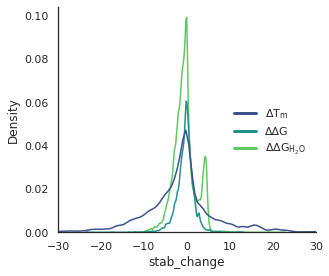

In [4]:
sns.set_theme(style='white')
# g = sns.displot(data=df, x='stab_change', kind='kde', bw_adjust=.4,
#                 hue='DELTA', #row='DELTA',
#                 height=4, aspect=1.2, legend=True,
#                 facet_kws={'sharex': True, 'sharey': False, 'xlim': (-30, 30)},
#                 row_order=delta_order, hue_order=delta_order, palette='viridis')
g = sns.displot(data=df, x='stab_change', kind='kde', bw_adjust=.4,
                hue='DELTA', #col='DELTA',
                height=4, aspect=1.2, legend=True,
                facet_kws={'sharex': True, 'sharey': True, 'xlim': (-30, 30)},
                col_order=delta_order, hue_order=delta_order, palette='viridis')
[l.set_linewidth(3) for l in g.legend.legendHandles]
relabel(g.legend)
g.legend.set(title='', bbox_to_anchor=(.75, .5))
g.savefig(wd / 'plots' / 'stab_change_distributions.png', dpi=300)

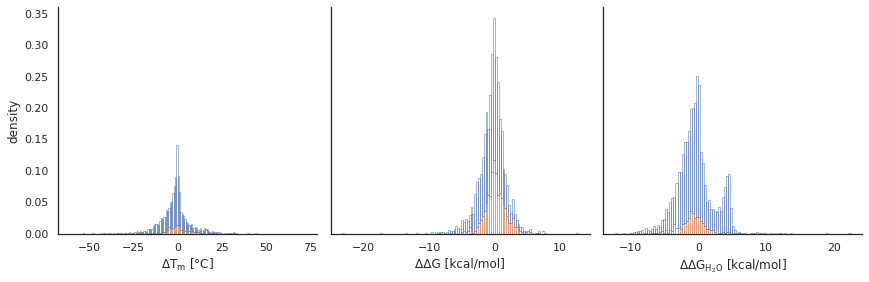

In [36]:
sns.set_theme(style='white')
g = sns.FacetGrid(data=df, col='DELTA',
                  aspect=1, height=4, sharey=True, sharex=False,
                  col_order=delta_order, hue_order=delta_order,
                  margin_titles=True, legend_out=True,
                  hue='DELTA', palette='viridis')
# g.map_dataframe(sns.kdeplot, data=df.loc[df.DATASET == 'full_set'], x='stab_change', bw_adjust=.3)
g.map_dataframe(sns.histplot, hue='DATASET', multiple='stack', fill=False,
                x='stab_change', stat='density')

g.set_axis_labels('stability change','density')
g.set_titles(col_template='')
for i, ax in enumerate(g.axes[0,]):
    ax.set_xlabel(lookup[delta_order[i]] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])

# g.savefig(wd / 'plots' / 'stab_change_distributions_hists.png', dpi=300)


### Distributions of the stability changes by non-mutation parameters

<ipython-input-24-d7397758d9e4>:56: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.axes[1,0].set_ylim(0,30)
<ipython-input-24-d7397758d9e4>:56: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.axes[1,0].set_ylim(0,30)


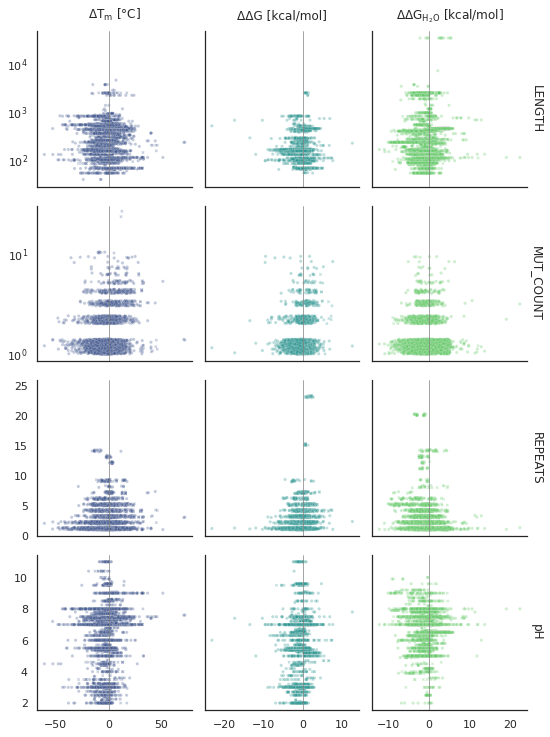

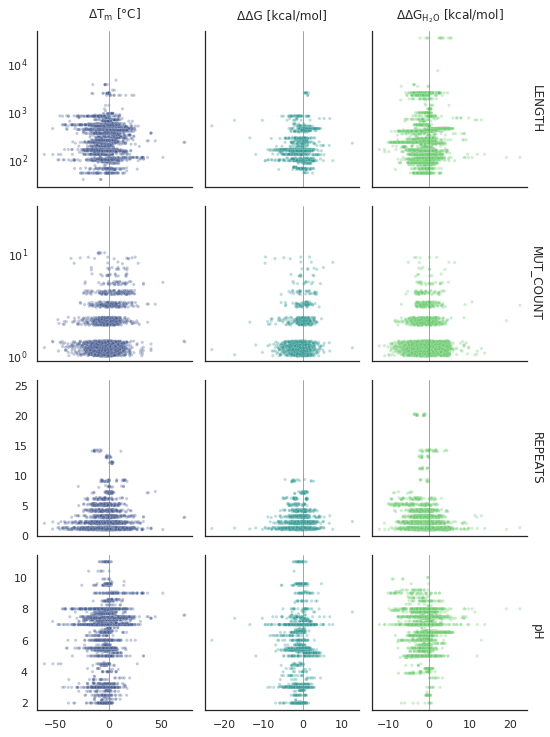

In [24]:
# plot the stability change as columns
# and the metrics to compare them to as rows
df = fresh_df().drop(columns=['UniProt_ID', 'MUTATION', 'MEASURE', 'METHOD'])

# # restrict
# df = df.loc[(df.LENGTH < 1200) & (df.MUT_COUNT < 11)]
# add jitter
df['MUT_COUNT'] += np.random.uniform(0, .4, len(df))
df['REPEATS'] += np.random.uniform(0, .4, len(df))
# collapse metrics into one column
df = df.fillna({d:0 for d in delta_order})
df['stab_change'] = df.pop('dtemp') + df.pop('ddg') + df.pop('h2o')

keepers = ['DELTA', 'stab_change', 'DATASET']
df = df.melt(id_vars=keepers, var_name='METRIC', value_name='metr_change',
             value_vars=[c for c in df.columns if c not in keepers])

# df
#
#
# #%%

sns.set_theme(style='white')

for idf, set_name in zip([df, df.loc[df.DATASET == 'reduced_set']], ['full_set', 'reduced_set']):
    g = sns.FacetGrid(data=idf,
                      col='DELTA', row='METRIC',
                      sharey='row', sharex='col', margin_titles=True,
                      hue_order=delta_order, col_order=delta_order,
                      row_order=sorted(idf.METRIC.unique()),
                      aspect=1, height=2.6,
                      hue='DELTA', palette='viridis')

    for i, ax in g.axes_dict.items():
        ax.axvline(x=0, color='.5', lw=.7)

    # g.map_dataframe(sns.kdeplot,
    #                 x='stab_change', y='metr_change',
    #                 color='.9',
    #                 alpha=1, levels=3)
    g.map_dataframe(sns.scatterplot,
                    x='stab_change', y='metr_change',
                    style='DATASET',
                    s=10, alpha=.3)

    g.set_titles(col_template='', row_template='{row_name}')
    for i, ax in enumerate(g.axes[0,]):
        ax.set_title(lookup[delta_order[i]]
                      + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i], pad=12)

    # for ax in g.axes[0, :]:
    #     ax.set_yscale('log')
    #     ax.set_ylim(40, 40000)
    g.axes[0,0].set_yscale('log')
    g.axes[1,0].set_yscale('log')
    g.axes[1,0].set_ylim(0,30)
    g.axes[2,0].set_ylim(0,26)


    # g.axes[2,0].set_yscale('log')
    # ax = g.axes[0,0]
    # ax.annotate('outliers\n cut off',
    #             xy=(50, 1200), xytext=(0,-40),
    #             xycoords='data', textcoords='offset points',
    #             ha='center', va='center',
    #             arrowprops=dict(arrowstyle='->', lw=1, color='.2'))
                                # connectionstyle=ConnectionStyle('angle', angleA=110, angleB=0, rad=32)))
    g.tight_layout()
    g.savefig(wd / 'plots' / ('changes_per_metric_%s.png' % set_name), dpi=300)


In [25]:
# ridge plots for MUT_COUNT and REPEATS -> no jitter

df = fresh_df().drop(columns=['UniProt_ID', 'MUTATION'])
# # restrict
# df = df.loc[(df.LENGTH < 1200) & (df.MUT_COUNT < 11)]
# collapse metrics into one column
df = df.fillna({d:0 for d in delta_order})
df['stab_change'] = df.pop('dtemp') + df.pop('ddg') + df.pop('h2o')
keepers = ['DELTA', 'stab_change', 'DATASET']
df = df.melt(id_vars=keepers, var_name='METRIC', value_name='metr_change',
             value_vars=[c for c in df.columns if c not in keepers])
df = df.loc[(df.METRIC == 'MUT_COUNT') & (df.DATASET == 'reduced_set')]  # previously: REPEATS
df.metr_change = df.metr_change.astype(int)
df


,DELTA,stab_change,DATASET,METRIC,metr_change
43740,dtemp,9.9,reduced_set,MUT_COUNT,1
43741,dtemp,2.3,reduced_set,MUT_COUNT,1
43742,dtemp,3.6,reduced_set,MUT_COUNT,1
43743,dtemp,1.0,reduced_set,MUT_COUNT,1
43744,dtemp,5.6,reduced_set,MUT_COUNT,3
...,...,...,...,...,...
58315,h2o,-0.6,reduced_set,MUT_COUNT,1
58316,h2o,-1.1,reduced_set,MUT_COUNT,1
58317,h2o,-0.9,reduced_set,MUT_COUNT,1
58318,h2o,-1.1,reduced_set,MUT_COUNT,1


/home/quirin/anaconda3/envs/skl/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/quirin/anaconda3/envs/skl/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/quirin/anaconda3/envs/skl/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


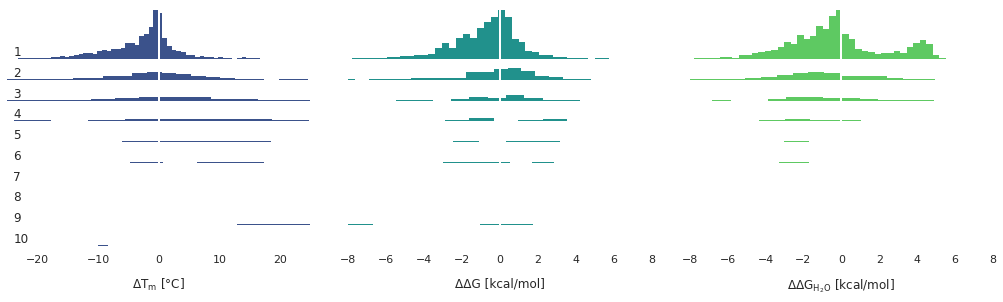

In [26]:
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

g = sns.FacetGrid(data=df,
                  col='DELTA', row='metr_change',
                  sharey='col', sharex='col', margin_titles=True,
                  hue_order=delta_order, col_order=delta_order,
                  row_order=sorted(df.metr_change.unique()),
                  aspect=12, height=.4,
                  hue='DELTA', palette='viridis')

# white contour
g.map_dataframe(sns.histplot, x='stab_change', # bw_adjust=.6, # for sns.kdeplot
                clip_on=True, color='w', lw=2)
# fill
g.map_dataframe(sns.histplot, x='stab_change', # bw_adjust=.6,
                clip_on=True, fill=True, linewidth=0, alpha=1)

g.set(xlim=(-25, 25))

for i, ax in enumerate(g.axes[:,0]):
    ax.set_xlim(-25,25)
    ax.text(-24, 0, i+1, va='bottom')
for ax in g.axes[:,1]:
    ax.set_xlim(-8,8)
for ax in g.axes[:,2]:
    ax.set_xlim(-8,8)

# bottom line
# g.map(plt.axhline, y=-.005, lw=1, clip_on=True)
g.map(plt.axvline, x=0, color='w', lw=2, clip_on=True)

g.fig.subplots_adjust(hspace=-.6)
g.set(yticks=[])
g.set_titles(col_template='', row_template='')

g.despine(bottom=True, left=True)
for i, ax in enumerate(g.axes[-1,]):
    ax.set_xlabel(lookup[delta_order[i]] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i],
                  labelpad=12)

g.savefig(wd / 'plots' / 'hill_line_mut_count_reduced_set_hist.png', dpi=300)


### which UniProt IDs are actually informative?
and what would I use that knowledge for?

    Do more mutations automatically mean a greater stability change?
    We cannot tell, the bar plots become too flat

    More repeats -> greater stability change doesn't make sense at all.
    Real repeats (=same id, same mutation pattern, same metric measured) can only
    tell us about the experimental error, and that is probably not constant either.

per length or per number of mutations
find a great change with many annotations?

### correction: there are on average 25 records per UniProt ID = per wildtype


### How many mutation patterns have repeats?
How different are they actually? Differentiate experimental error from different experiments


In [59]:
df = fresh_df()

# number of unique mutation patterns
uniq = len(df.MUTATION.unique())
uniq

repeated = len(df.loc[df.REPEATS > 1, 'MUTATION'].unique())
repeated

df = df.loc[df.REPEATS > 1]
dt = df.loc[df.MUTATION == 'R96H']

### Look at the ddgh2o peak
and what